In [ ]:
!pip install mlflow

2025/03/04 14:55:29 INFO mlflow.tracking.fluent: Experiment with name 'Text Classification Model Selection' does not exist. Creating a new experiment.


Naive Bayes - AUC: 0.9742, Accuracy: 0.9677, Precision: 0.9688, Recall: 0.9677, F1-score: 0.9657


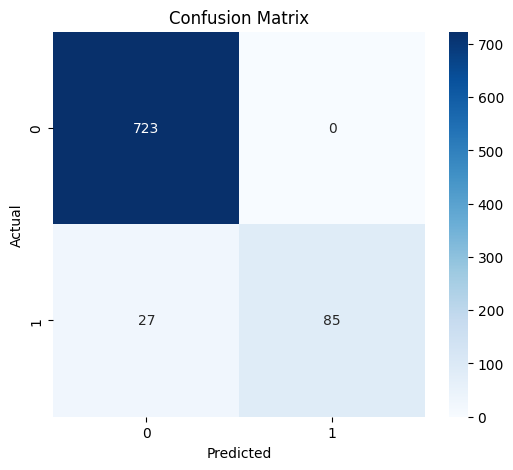

2025/03/04 14:55:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - AUC: 0.9889, Accuracy: 0.9844, Precision: 0.9844, Recall: 0.9844, F1-score: 0.9842


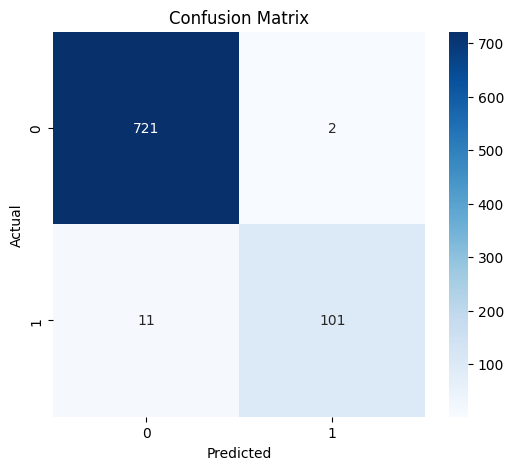

2025/03/04 14:55:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM - AUC: 0.9890, Accuracy: 0.9784, Precision: 0.9787, Recall: 0.9784, F1-score: 0.9777


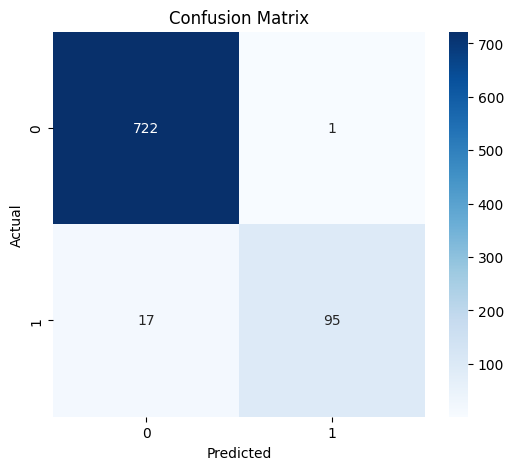

2025/03/04 14:55:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Best model selected based on AUC, evaluating on test set...
Test AUC: 0.9958, Accuracy: 0.9809, Precision: 0.9810, Recall: 0.9809, F1-score: 0.9803


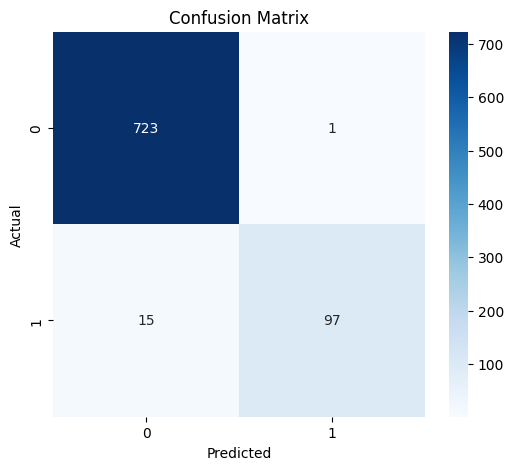

2025/03/04 14:55:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def fine_tune_model(model, X_train, y_train):
    """ Tune Logistic Regression Hyperparameters """
    param_grid = {'C': [0.1, 1, 10]} if isinstance(model, LogisticRegression) else {}

    if param_grid:
        grid_search = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5)
        grid_search.fit(X_train, y_train)
        return grid_search.best_estimator_

    return model

def score_model(model, X, y):
    """ Evaluate Model Performance with AUC-ROC """
    if hasattr(model, "predict_proba"):  # Logistic Regression, Naive Bayes
        y_prob = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):  # SVM
        y_prob = model.decision_function(X)
    else:
        y_prob = model.predict(X)  # Fallback to normal predictions

    auc = roc_auc_score(y, y_prob)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')
    cm = confusion_matrix(y, y_pred)
    return auc, acc, precision, recall, f1, cm

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def main():
    # Load Data
    train = pd.read_csv('train.csv').dropna()
    validation = pd.read_csv('validation.csv').dropna()
    test = pd.read_csv('test.csv').dropna()

    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(train['message'])
    y_train = train['label']
    X_val = vectorizer.transform(validation['message'])
    y_val = validation['label']
    X_test = vectorizer.transform(test['message'])
    y_test = test['label']

    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC(probability=True)  # Enable probability estimates
    }

    best_model = None
    best_auc = 0

    mlflow.set_experiment("Text Classification Model Selection")

    for name, model in models.items():
        with mlflow.start_run(run_name=name):
            model = train_model(model, X_train, y_train)
            model = fine_tune_model(model, X_train, y_train)
            auc, acc, precision, recall, f1, cm = score_model(model, X_val, y_val)

            # Log Metrics to MLflow
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Accuracy", acc)
            mlflow.log_metric("Precision", precision)
            mlflow.log_metric("Recall", recall)
            mlflow.log_metric("F1 Score", f1)

            print(f"{name} - AUC: {auc:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
            plot_confusion_matrix(cm)

            # Log and Save Model
            mlflow.sklearn.log_model(model, name)
            mlflow.log_artifact("train.csv")

            if auc > best_auc:
                best_auc = auc
                best_model = model

    print("\nBest model selected based on AUC, evaluating on test set...")
    auc, acc, precision, recall, f1, cm = score_model(best_model, X_test, y_test)
    print(f"Test AUC: {auc:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    plot_confusion_matrix(cm)

    # Save the best model in MLflow
    with mlflow.start_run(run_name="Best_Model"):
        mlflow.sklearn.log_model(best_model, "Best_Model")
        mlflow.log_metric("Test AUC", auc)
        mlflow.log_metric("Test Accuracy", acc)
        mlflow.log_metric("Test Precision", precision)
        mlflow.log_metric("Test Recall", recall)
        mlflow.log_metric("Test F1 Score", f1)

if __name__ == "__main__":
    main()


In [34]:
!git rebase --abort

In [35]:
!git push --force origin main

Enumerating objects: 107, done.
Counting objects: 100% (107/107), done.
Delta compression using up to 2 threads
Compressing objects: 100% (72/72), done.
Writing objects: 100% (107/107), 8.89 MiB | 1.38 MiB/s, done.
Total 107 (delta 20), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (20/20), done.
To https://github.com/DharmiMalde/AppliedMachineLearning.git
 + 3e3d653...9addbb6 main -> main (forced update)


In [38]:
!git add .
!git commit -m "Added models"
!git push origin main


hint: You've added another git repository inside your current repository.
hint: Clones of the outer repository will not contain the contents of
hint: the embedded repository and will not know how to obtain it.
hint: If you meant to add a submodule, use:
hint: 
hint: 	git submodule add <url> AppliedMachineLearning
hint: 
hint: If you added this path by mistake, you can remove it from the
hint: index with:
hint: 
hint: 	git rm --cached AppliedMachineLearning
hint: 
hint: See "git help submodule" for more information.
[main 794f920] Added models
 1 file changed, 1 insertion(+)
 create mode 160000 AppliedMachineLearning
Enumerating objects: 3, done.
Counting objects: 100% (3/3), done.
Delta compression using up to 2 threads
Compressing objects: 100% (2/2), done.
Writing objects: 100% (2/2), 278 bytes | 278.00 KiB/s, done.
Total 2 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/DharmiMalde/AppliedMachine